In [0]:
"""

Copyright (C) 2019-2020 - Author: Damiano Perri

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

Anyone who wants to use this code must mention the author.

"""

'\n\nCopyright (C) 2019-2020 - Author: Damiano Perri\n\nThis program is free software: you can redistribute it and/or modify\nit under the terms of the GNU General Public License as published by\nthe Free Software Foundation, either version 3 of the License, or\n(at your option) any later version.\n\nThis program is distributed in the hope that it will be useful,\nbut WITHOUT ANY WARRANTY; without even the implied warranty of\nMERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the\nGNU General Public License for more details.\n\nYou should have received a copy of the GNU General Public License\nalong with this program.  If not, see <http://www.gnu.org/licenses/>.\n\nAnyone who wants to use this code must mention the author.\n\n'

In [0]:


listOfClasses                 = ["neutral","happy","surprise"] # names
myColabProjectPath            ="/content/drive/My Drive/Colab Notebooks/folder/"
rawDatasetColabPath           =myColabProjectPath+"rawDataset.zip"
datasetColabPath              =myColabProjectPath+"dataset.zip"
wrongPredictedColabPath       =myColabProjectPath+"wrongPredicted.zip"
bestmodel                     ="weights.best.hdf5"
checkpointOnDrivePathBaseName =myColabProjectPath+"models/" # extension added at runtime
path                          ="/content/dataset/"
pathRawDataset                ="/content/rawDataset/"
pathWrongPredicted            ="wrongPredicted"
pathElaboratedImages          ="elaboratedImages/" # not used for this work
shapePredictorPath            =myColabProjectPath+"shape_predictor_68_face_landmarks.dat"

from google.colab import drive
import dlib
from os import listdir
from os.path import isfile, join
import numpy
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 #, preprocess_input, decode_predictions
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.applications.inception_v3 import InceptionV3 , preprocess_input, decode_predictions
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation, Dropout, Flatten, Conv2D,MaxPooling2D,Dense,concatenate,GlobalAveragePooling2D
from sklearn.metrics import classification_report,confusion_matrix
from os import listdir
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

import os
from copy import copy, deepcopy
import shutil
import sys
import glob
import pickle
import tensorflow as tf
import itertools
import tensorflow
import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from datetime import datetime
drive.mount('/content/drive')
print("Library loaded")

In [0]:
#!unzip -qq "/content/drive/My Drive/Colab Notebooks/bocca/dataset.zip"
#os.rename("/content/dataset", "/content/datasetBK")

!cp -r "$rawDatasetColabPath" "/content/rawDataset.zip"
!unzip -qq "/content/rawDataset.zip"
!mv /content/content/rawDataset /content/rawDataset


In [0]:
imgNumber=1
def contaImmagini():
  print("Raw dataset:")
  for className in listOfClasses:
    print(className)
    path="/content/rawDataset/"+className
    !ls $path | wc -l
    print("____")
  print("dataset:")
  for className in listOfClasses:
    print(className)
    path="/content/dataset/"+className
    !ls $path | wc -l
    print("____")

def rotate(image, angle=90, scale=1.2):
    w = image.shape[1]
    h = image.shape[0]
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
    image = cv2.warpAffine(image,M,(w,h))
    return image

def flip(image, vflip=False, hflip=False):
    if hflip or vflip:
        if hflip and vflip:
            c = -1
        else:
            c = 0 if vflip else 1
        image = cv2.flip(image, flipCode=c)
    return image 

def loadImages(path,listOfClasses):
  print("Analyzing "+path+listOfClasses)
  path=path+listOfClasses+"/"
  imagesList = listdir(path)
  loadedImages = []
  counter=0
  for image in imagesList:
    counter=counter+1
    if counter==5000 and 1==1:
      print("max number of images reached for the listOfClasses "+listOfClasses)
      return loadedImages
    #print(listOfClasses+": "+str(round(100*float(counter)/(len(imagesList),3)) + "% - Working on "+item ) )
    try: 
      img = cv2.imread(path + image)  
      loadedImages.append(img)
    except:
      try:
        print("err: "+path+image)
      except:
        print("undefined error on folder "+listOfClasses)
  
  return loadedImages

def loadDataset():
  global dataset,label
  try:
    if os.path.exists(pathElaboratedImages):
      shutil.rmtree(pathElaboratedImages)
    os.mkdir(pathElaboratedImages)
  except:
    print("Problem accessing to "+pathElaboratedImages)
  for i in range(0,len(listOfClasses)):
    images=loadImages(path,listOfClasses[i])
    for j in range(0,len(images)):
      dataset.append(images[j])
      label.append(i)
  print("Dataset allocated, "+str(len(dataset))+" samples")
  if normalizeDataset==1:
    dataset = np.asarray(dataset).astype(np.float32)/ 255.0
  else:
    dataset = np.asarray(dataset)    
  label = np.asarray(label)
  label = to_categorical(label)
  X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=54 )
  return X_train, X_test, y_train, y_test


def generateDataset():
  predictor_path = shapePredictorPath
  faces_folder_path = "rawDataset"
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(predictor_path)
  #win = dlib.image_window()
  if os.path.exists(path):
    pass
  else:
    os.mkdir(path)
  choice =input("Do you want to delete the previous dataset ? 1/0: ")
  if choice=="1":
    for i in range(0,len(listOfClasses)):      
      if os.path.exists(path+listOfClasses[i]):
        shutil.rmtree(path+listOfClasses[i])
      os.mkdir(path+listOfClasses[i])
  for counter in range(0,len(listOfClasses)):
    searchPath=pathRawDataset+listOfClasses[counter]
    print("Analyzing "+searchPath)
    savingPath=path+listOfClasses[counter]+"/"
    counterImg=0

    for f in glob.glob(os.path.join(searchPath, "*.jpg")):
      img = cv2.imread(f)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
      dets= detector(img, 1)
      try:
        for i, d in enumerate(dets):
          crop = img[d.top():d.bottom(), d.left():d.right()]
          img = cv2.resize(crop, (height, width))
          filename = os.path.splitext(os.path.basename(f))[0]
          if(useDataAugmentation==1): ######## DATA AUGMENTATION
            dataAugmentationAndSave(img,savingPath,filename)
          else:
            cv2.imwrite(savingPath+filename+'.jpg',img)
          counterImg+=1
      except Exception as e:
        print("skipping image")
        print(e)
        continue
      if counterImg>maxImg:
        break
  menu()


def dataAugmentationAndSave(img,savingPath,filename):
  img_flip  = flip(img, vflip=False, hflip=True)
  img_rot   = rotate(img,4)
  img_rot2  = rotate(img,-4)    
  img_rot3  = rotate(img_flip,4)
  img_rot4  = rotate(img_flip,-4) 
  cv2.imwrite(savingPath+filename+'.jpg',img)
  cv2.imwrite(savingPath+filename+'_Flip.jpg',img_flip)
  cv2.imwrite(savingPath+filename+'_R4.jpg',img_rot)
  cv2.imwrite(savingPath+filename+'_R-4.jpg',img_rot2)
  cv2.imwrite(savingPath+filename+'_R4Flip.jpg',img_rot3)
  cv2.imwrite(savingPath+filename+'_R-4Flip.jpg',img_rot4)
  print("saved.."+savingPath+filename+'.jpg')

def loadModel(modelFilename=""):
  model=getModel()
  if modelFilename=="":
        modelFilename=input("Insert filename to load (with extension) : ")
        modelFilename="./"+modelFilename
  print("Searching for: "+modelFilename)
  model.load_weights(modelFilename)   
  print("Model loaded")
  return model

def reloadPreviousState():
  X_train= pickle.load(open("X_train.data","rb"))
  X_test = pickle.load(open("X_test.data","rb"))
  y_train= pickle.load(open("y_train.data","rb"))
  y_test = pickle.load(open("y_test.data","rb"))
  return X_train, X_test, y_train, y_test

def saveOnDrive():
  elementToSave=["X_test.data","X_train.data","y_test.data","y_train.data","model.h5","weights.best.hdf5"]
  for e in elementToSave:
    p1="/content/"+e
    p2=myColabProjectPath+e
    !cp "$p1" "$p2"

def saveCurrentState(X_train, X_test, y_train, y_test):  
  pickle.dump(X_train, open("X_train.data", "wb"))
  pickle.dump(X_test, open("X_test.data", "wb"))
  pickle.dump(y_train, open("y_train.data", "wb"))
  pickle.dump(y_test, open("y_test.data", "wb"))
  if(saveCheckpointToDrive==1 and 1==2):
    choice =input("Do you want to save the train, test data on the subfolder in drive ?: ")
    if choice=="1":
      saveOnDrive()
  
def menu():
  print("What do you want to do ?")
  print("Insert 1 for generate the dataset from the raw dataset")
  print("Insert 2 for traing the network from the generated dataset")
  print("Insert 3 for restore learning")
  print("Insert 4 load previous data and test from disk and fast start the training from scratch")
  print("Insert 5 for count the images in the raw dataset")
  print("Insert 6 for print the best model results")
  print("Or press enter for exit")
  choice =input("Insert: ")
  if choice=="1":
    generateDataset()
  elif choice=="2":
    pretraining()
  elif choice=="3":
    continuosLearning()
  elif choice=="4":
    reloadAndTest()
  elif choice=="5":
    contaImmagini()
  elif choice=="6":
    bestModelResults()
  else:
    print("Bye bye")
    return

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion_matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    global imgNumber
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    plt.figure(imgNumber)
    imgNumber=imgNumber+1
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if saveCheckpointToDrive:
      title.replace(" ", "_")
      plt.savefig(checkpointOnDrivePath+title+".png")

def calculateConfusionMatrix(model,X,y,setName,typeModel):
  trueValue=np.argmax(y,axis=1)
  predicted=model.predict(X)
  predicted=np.argmax(predicted,axis=1)
  cm=confusion_matrix(trueValue,predicted)
  cm_plot_labels = listOfClasses
  plot_confusion_matrix(cm, cm_plot_labels,normalize=False, title=setName+" "+typeModel)
  plot_confusion_matrix(cm, cm_plot_labels,normalize=True, title=setName+' Normalized '+typeModel)

def getResults(history,model,X_test,y_test,X_train,y_train):
  global imgNumber
  plt.figure(imgNumber)
  imgNumber=imgNumber+1
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  if saveCheckpointToDrive:
    plt.savefig(checkpointOnDrivePath+"modelAccuracy.png")
  plt.show()
  plt.figure(imgNumber)
  imgNumber=imgNumber+1
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  if saveCheckpointToDrive:
    plt.savefig(checkpointOnDrivePath+"modelLoss.png")
  plt.show()
  calculateConfusionMatrix(model,X_test,y_test,"validation","final")
  calculateConfusionMatrix(model,X_train,y_train,"training","final")

  model=getModel()
  model.load_weights("/content/weights.best.hdf5") 
  calculateConfusionMatrix(model,X_test,y_test,"validation","best")
  calculateConfusionMatrix(model,X_train,y_train,"training","best")
  if saveWrongPredicted==1:
    if os.path.exists(pathWrongPredicted):
      shutil.rmtree(pathWrongPredicted)
    os.mkdir(pathWrongPredicted)
    contatore=0
    predicted=model.predict(X_test)
    predicted=np.argmax(predicted,axis=1)
    for i in range(0,len(X_test)):
        realClass=np.argmax(y_test[i])
        if(realClass!=predicted[i]):
          contatore+=1
          name="/"+listOfClasses[predicted[i]]+"_instendOf_"+listOfClasses[realClass]+"_"+str(contatore)+".jpg"
          cv2.imwrite(pathWrongPredicted+name,X_test[i])

def training(model,X_train, X_test, y_train, y_test):
  checkpoint = ModelCheckpoint(bestmodel, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  #,shuffle=True
  aug = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
		rotation_range=3,
		zoom_range=0.2,
		shear_range=0.05,
		horizontal_flip=True,
		vertical_flip=False,
		fill_mode="nearest")
  aug.fit(X_train)
  y_integers = np.argmax(y_train, axis=1)
  class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
  d_class_weights = dict(enumerate(class_weights))
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
  callbacks_list = [
                    checkpoint
                    ,tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patienceBeforeStop*2)
                    #,learning_rate_reduction
                    ]
  if(saveCheckpointToDrive==1):
    callbacks_list.append(
        ModelCheckpoint(checkpointOnDrivePathModel, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    )
  history=model.fit(
      aug.flow(X_train, y_train, batch_size=batchSize)
      ,validation_data=(X_test, y_test)
      ,steps_per_epoch=len(X_train) // batchSize
      ,epochs=epocNumber
      ,callbacks=callbacks_list
      ,verbose=1
      #,class_weight=d_class_weights
      )
  
  print("Saving model")
  model.save_weights('model.h5') 
  getResults(history,model,X_test,y_test,X_train,y_train)

def bestModelResults():
  model = load_model("/content/weights.best.hdf5") 
  X_train, X_test, y_train, y_test=reloadPreviousState()
  calculateConfusionMatrix(model,X_test,y_test,"validation","best")
  calculateConfusionMatrix(model,X_train,y_train,"training","best")

def continuosLearning():
  try:
    print("Trying to load the best model previuous training")
    model = load_model("weights.best.hdf5") 
  except:
    print("Trying to load the final model previuous training")
    model = load_model("model.h5") 
  X_train, X_test, y_train, y_test=reloadPreviousState()
  training(model,X_train, X_test, y_train, y_test)

def getModelVGG16():
  print("Creating model")
  input_tensor = Input(shape=(width, height, 3))
  base_model=applications.VGG16(weights='imagenet',include_top=False,input_tensor=input_tensor)
  base_model.trainable = False
  add_model = Sequential()
  add_model.add(base_model)
  add_model.add(Flatten())  
  add_model.add(Dense(64,activation="relu"))
  add_model.add(Dense(64,activation="relu"))
  add_model.add(Dense(len(listOfClasses),activation='softmax'))
  model=add_model
  opt=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
  model.compile (loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model.summary()
  print("Model created")
  return model

def getModelInceptionV3():
  print("Creating model")
  base_model = applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(width, height, 3))
  base_model.trainable = False
  add_model = Sequential()
  add_model.add(base_model)
  add_model.add(Flatten())
  add_model.add(Dense(64,activation="relu"))
  add_model.add(Dense(64,activation="relu"))
  add_model.add(Dense(len(listOfClasses),activation='softmax'))
  model = add_model
  opt=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
  model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
  model.summary()
  print("Model created")
  return model

def getModelXception():
  print("Creating model")
  base_model = tensorflow.keras.applications.xception.Xception(weights='imagenet',include_top=False,input_shape=(width, height, 3))
  base_model.trainable = False
  add_model = Sequential()
  add_model.add(base_model)
  add_model.add(Flatten())  
  #add_model.add(Dense(128, activation='relu'))
  add_model.add(Dense(len(listOfClasses),activation='softmax'))
  model = add_model
  opt=optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=True)
  model.compile(loss='categorical_crossentropy',optimizer="adam", metrics=['accuracy'])
  model.summary()
  print("Model created")
  return model

def getModelXception():
  print("Creating model")
  base_model = tensorflow.keras.applications.xception.Xception(weights='imagenet',include_top=False,input_shape=(width, height, 3))
  base_model.trainable = False
  add_model = Sequential()
  add_model.add(base_model)
  add_model.add(GlobalAveragePooling2D())   
  add_model.add(Flatten())  
  #add_model.add(Dense(200, activation='relu'))
  add_model.add(Dense(128, activation='relu'))
  add_model.add(Dense(len(listOfClasses),activation='softmax'))
  model = add_model
  opt=optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=True)
  model.compile(loss='categorical_crossentropy',optimizer="adam", metrics=['accuracy'])
  model.summary()
  print("Model created")
  return model
  
def myModel():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(width, height, 3)))
  model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.40))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(len(listOfClasses), activation='softmax'))
  model.summary()
  optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
  return model

def myModel70_ACC():
  modelN = Sequential()
  modelN.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                          input_shape=(width, height, 3)))
  modelN.add(MaxPooling2D(pool_size=(2, 2)))
  modelN.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  modelN.add(MaxPooling2D(pool_size=(2, 2)))
  modelN.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  modelN.add(MaxPooling2D(pool_size=(2, 2)))
  modelN.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  modelN.add(MaxPooling2D(pool_size=(2, 2)))
  modelN.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  modelN.add(MaxPooling2D(pool_size=(2, 2)))
  modelN.add(Flatten()) 
  modelN.add(Dense(128, activation='relu'))
  modelN.add(Dense(64, activation='relu'))
  modelN.add(Dense(32, activation='relu'))
  modelN.add(Dense(len(listOfClasses), activation='softmax'))

  # optimizer:
  modelN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  modelN.summary()
  return modelN

def getModelInceptionResNetV2():
  print("Creating model")
  base_model=tensorflow.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', 
                                                                                 include_top=False, input_shape=(width, height, 3))
  base_model.trainable = True
  add_model = Sequential()
  add_model.add(base_model)
  add_model.add(Flatten())  
  add_model.add(Dense(64, activation='relu'))
  add_model.add(Dense(64, activation='relu'))
  add_model.add(Dense(len(listOfClasses),activation='softmax'))
  model = add_model
  opt=SGD(lr=0.0006, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
  model.summary()
  print("Model created")
  return model

def pretraining():
  X_train, X_test, y_train, y_test=loadDataset()
  saveCurrentState(X_train, X_test, y_train, y_test)
  model=getModel()
  training(model,X_train, X_test, y_train, y_test)

def reloadAndTest():
  X_train, X_test, y_train, y_test=reloadPreviousState()
  model=getModel()
  training(model,X_train, X_test, y_train, y_test)

def getModel():
  if modelName=="xception":
    model=getModelXception()
  elif modelName=="vgg16":
    model=getModelVGG16()
  elif modelName=="inceptionv3":
    model=getModelInceptionV3()
  elif modelName=="resnet":
    model=getModelInceptionResNetV2()
  elif modelName=="custom":
    model=myModel()
  else:
    print("no valid model name, check input, loading xception")
    model=myModel70_ACC()
  return model

print("functions loaded")

functions loaded


In [0]:
dataset=[]
label=[]
useDataAugmentation=0 # use data augmentation BEFORE splitting (phase 1)
width=299
height=299
maxImg=400 #max IMG for each classes
normalizeDataset=1 # insert 1 for do dataset /255 
saveCheckpointToDrive=1 # 0 = only local checkpoint ; 1 = save check point to google drive
modelName="vgg16"  #Specify model xception,vgg16,inceptionv3,"resnet,custom
epocNumber=15
batchSize=25
patienceBeforeStop=5 # numero di epoche senza miglioramenti, oltre il quale l'esecuzione di stoppa
saveWrongPredicted=0 # 0 = don't save the wrong predicted images in a folder, 1=save the wrong predicted images in another folder (copy)
K.set_learning_phase(1)  

In [0]:
# Do not touch these variables
checkpointOnDrivePath=checkpointOnDrivePathBaseName+modelName+"-"+datetime.now().strftime("%d-%b-%Y--%H-%M-%S")+"/"
os.mkdir(checkpointOnDrivePath)
checkpointOnDrivePathModel=checkpointOnDrivePath+"Epoch:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
#
K.set_learning_phase(1)
menu() # sotto ho il fast start
#generateDataset()
#pretraining()

QUI SOTTO CI SONO LE ESECUZIONI SALVATE

What do you want to do ?
Insert 1 for generate the dataset from the raw dataset
Insert 2 for traing the network from the generated dataset
Insert 3 for restore learning
Insert 4 load previous data and test from disk and fast start the training from scratch
Insert 5 for count the images in the raw dataset
Insert 6 for print the best model results
Or press enter for exit
Insert: 2
Analyzing /content/dataset/neutral
Analyzing /content/dataset/happy
Analyzing /content/dataset/surprise
Dataset allocated, 1197 samples
Creating model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 98304)             0         
_________________________________________________________________
dense (Dense)                (None, 64)            

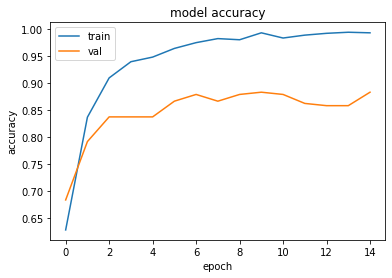

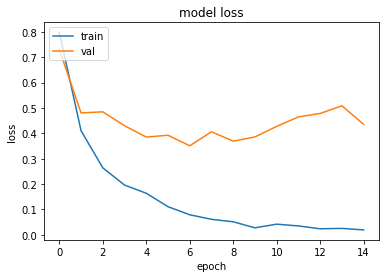

Creating model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                6291520   
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 60,632,611
Trainable params: 60,572,067
Non-trainable params: 60,544
_________________________________________________________________
Model created


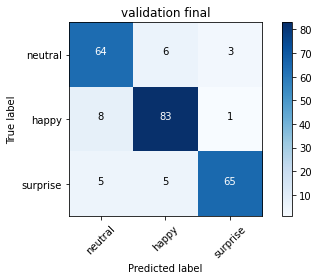

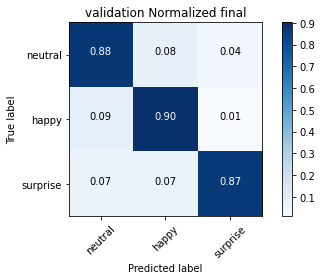

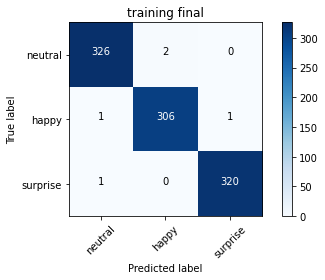

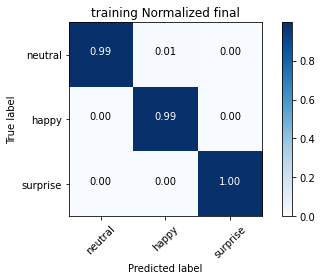

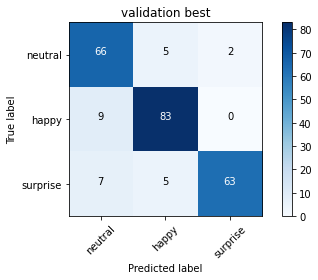

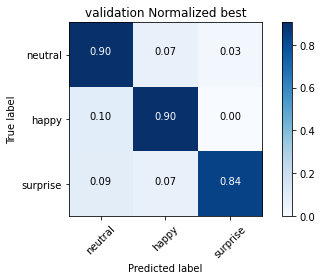

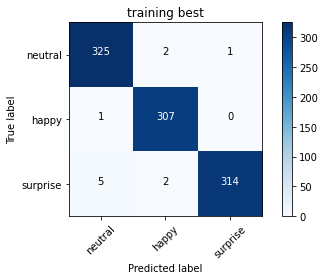

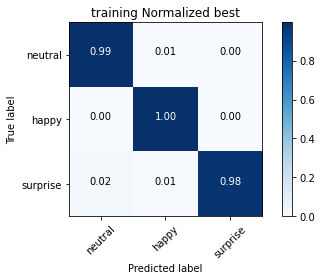

In [0]:
# Do not touch these variables
checkpointOnDrivePath=checkpointOnDrivePathBaseName+modelName+"-"+datetime.now().strftime("%d-%b-%Y--%H-%M-%S")+"/"
os.mkdir(checkpointOnDrivePath)
checkpointOnDrivePathModel=checkpointOnDrivePath+"Epoch:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
#
K.set_learning_phase(1)
menu() # sotto ho il fast start
#generateDataset()
#pretraining()

In [0]:
# SALVO TUTTO LO STATO ATTUALE SU GOOGLE
#elementToSave=["X_test.data","X_train.data","y_test.data","y_train.data","model.h5","weights.best.hdf5"]
saveOnDrive()

In [0]:
###SALVO RAW DATASET
!zip -r -0 "/content/rawDataset.zip" "/content/rawDataset"
!cp "/content/rawDataset.zip" "$rawDatasetColabPath"

In [0]:
###SALVO DATASET
!zip -r -0 "/content/dataset.zip" "/content/dataset"
!cp "/content/dataset.zip" "$datasetColabPath"


In [0]:
###Carico DATASET
!cp "$datasetColabPath" "/content/dataset.zip"
!unzip -qq "/content/dataset.zip"
!mv /content/content/dataset /content/dataset

In [0]:
#SALVO I PREDETTI MALE 
!zip -r -0 "/content/wrongPredicted.zip" "/content/wrongPredicted" 
!cp "/content/wrongPredicted.zip" "$wrongPredictedColabPath"

In [0]:
###SALVO DATASET
!zip -r -0 "/content/dataset299Completo.zip" "/content/dataset"
!cp "/content/dataset299Completo.zip" "/content/drive/My Drive/Colab Notebooks/bocca/dataset299Completo.zip"

In [0]:
contaImmagini()

Raw dataset:
neutral
1239
____
happy
562
____
surprise
463
____
dataset:
neutral
401
____
happy
401
____
surprise
401
____
